In [2]:
from model import Model
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# Read in data
img_size = 128
data_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size)
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [4]:
dataset.class_to_idx

{'colon_image_sets': 0, 'lung_image_sets': 1}

In [5]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

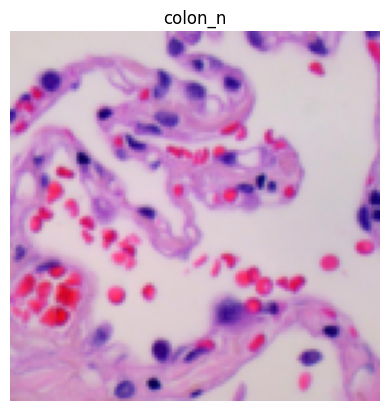

In [6]:
# The function to show an image.
def display_img(img, label):
    img = img / 2 + 0.5     # Unnormalize.
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(classes[label])
    plt.axis('off')
    plt.show()

classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
# Get some random training images.
images, labels = next(iter(train_loader))
# Show an image
display_img(images[0], labels[0])

In [7]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)  

cuda:0


In [8]:
class MaxPoolCNN(nn.Module):
    def __init__(self):
        super(MaxPoolCNN, self).__init__()
        # First CNN block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second CNN block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third CNN block
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fourth CNN block 
        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Fifth CNN block 
        self.conv9 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(256)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 24 * 24, 1024)
        self.bn11 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn12 = nn.BatchNorm1d(512)
        
        # Output layer
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        # First CNN block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        # Second CNN block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        # Third CNN block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        # Fourth CNN block
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        # Fifth CNN block
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.pool5(x)

        # Flatten
        x = torch.flatten(x, 1)
        x = F.relu(self.bn11(self.fc1(x)))
        x = F.relu(self.bn12(self.fc2(x)))
        x = self.fc3(x)
        return x
    
maxPoolNet = MaxPoolCNN()     # Create the network instance.
maxPoolNet.to(device)  # Move the network parameters to the specified device.

MaxPoolCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [9]:
def trainNN(network, train_loader, loss_function, optimizer, epochs):
    avg_losses = []   # Avg. losses.
    print_freq = 1000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, (inputs, labels) in enumerate(train_loader):
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward step.
            outputs = network(inputs)
            loss = loss_function(outputs, labels)
            # Backward step.
            loss.backward()
            # Optimization step (update the parameters).
            optimizer.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every (print_freq) mini-batches.
                avg_loss = running_loss / print_freq
                print('[Epoch: {}/{}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, epochs, i+1, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')#### Training Procedure
    

In [ ]:
# We use cross-entropy as loss function; Adam as optimizer
model = Model('relu', 'max', img_size, elu_val = 1, lrelu_val = .01)
model = model.to(device)
trainNN(model, train_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001), 5)